# Project 2. P2P  대출심사 알고리듬
**과목명:  응용데이터애널리틱스 (Applied Data Analytics)** \\
**학수번호:  INE4108** \\
**교강사:  송재욱 교수 (산업공학과)** \\
 \\
***

## 1. Environmental Set-up & Data Loading

In [ ]:
from google.colab import drive
import pandas as pd

drive.mount('/content/drive', force_remount=True)

# enter the foldername in your Google Drive where you have saved the unzipped
FOLDERNAME =  'ADX/'

assert FOLDERNAME is not None, 'ERROR'

%cd drive/My\ Drive
%cp -r $FOLDERNAME ../../


Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.activity.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fexperimentsandconfigs%20https%3a%2f%2fwww.googleapis.com%2fauth%2fphotos.native&response_type=code

Enter your authorization code:
4/1AX4XfWiDO9GErA0AKJToeONI-kTCnKR6xn2HLPY14OxKkiC8VBHF52Dw1d8


In [ ]:
# 모델 수립을 위한 Train/Validation Set
df = pd.read_csv('/content/drive/Shareddrives/응용데이터애널리틱스/기말/P2_dataset.csv', encoding ='cp949') 

# 시스템 구현을 위한 Test Set 샘플
df_test = pd.read_csv('/content/drive/Shareddrives/응용데이터애널리틱스/기말/P2_dataset_test_sample.csv', encoding ='cp949') 

In [ ]:
from sklearn.model_selection import train_test_split

# loan_status의 기존 비율에 맞게 Split
x_train, x_val, y_train, y_val = train_test_split(df, df['loan_status'], test_size=0.2, random_state=77, stratify=df['loan_status']) 
x_train = x_train.reset_index().drop(['index'],axis=1)
y_train = y_train.reset_index().drop(['index'],axis=1)
x_val = x_val.reset_index().drop(['index'],axis=1)
y_val = y_val.reset_index().drop(['index'],axis=1)


df=x_train

df_val=x_val

## 2. Modelling
- df를 사용하여 예측모형 수립
- Feature engineering에 대한 토의/구현 진행
- Computation time을 고려하여 전체 데이터를 완전히 사용하지 말고 Sampling하여 Model Train/Vadliation을 진행하는 것을 추천
- Sampling을 단 한번 한 것으로 모형 Train 한 것이 과연 옳은 것인지에 대해 팀원들과 고민해볼 것. 해결 방법은 없을지 서치해보는 것도 하나의 task임.

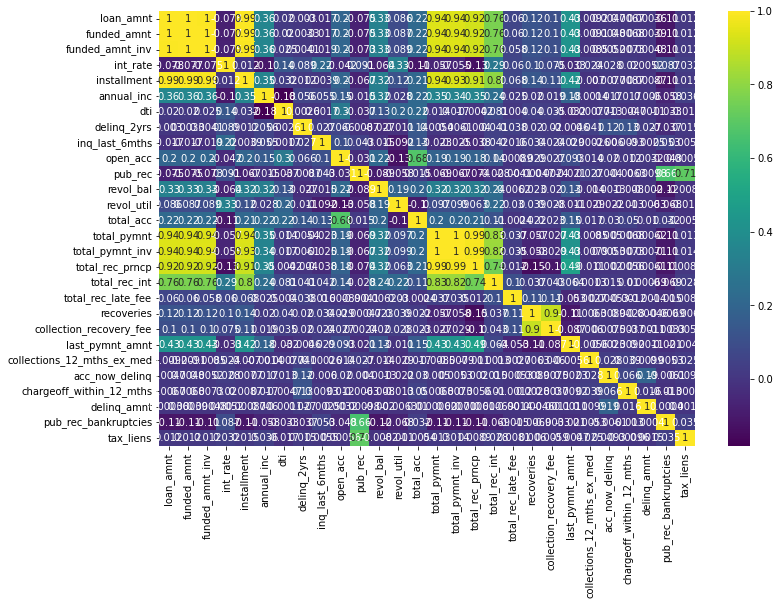

In [ ]:
# 각 변수들간의 상관관계 파악, 시각화
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

plt.figure(figsize=(12, 8))
sns.heatmap(df.corr(), annot=True, cmap='viridis')

변수들 간의 상관관계를 보았을때 0.9 이상으로 강한 상관관계에 있는 변수들을 확인할 수 있고 이들을 제거하기 보다 PCA 선형변환을 통해 차원을 축소하는 방향으로 진행한다.  
그 대상은 다음 7개의 변수  
['loan_amnt', 'funded_amnt', 'funded_amnt_inv', 'installment', 'total_pymnt', 'total_pymnt_inv', 'total_rec_prncp']

In [ ]:
# PCA
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA

col_PCA = ['loan_amnt', 'funded_amnt', 'funded_amnt_inv', 'installment', 'total_pymnt', 'total_pymnt_inv', 'total_rec_prncp']
x = df[col_PCA]
scaler = StandardScaler()
scaler.fit(x)
scaled_X_train = scaler.transform(x)

pca = PCA(n_components=2) #PCA 객체 생성 (주성분 갯수 2개 생성)
pca.fit(scaled_X_train)
principalComponents = pca.transform(scaled_X_train)
principalDf = pd.DataFrame(data = principalComponents, columns = ['PCA_1', 'PCA_2'])
principalDf

,PCA_1,PCA_2
0,-0.841232,2.224233
1,1.096563,-0.127242
2,-1.153697,-0.136548
3,0.007345,-0.111110
4,4.336224,-0.098895
...,...,...
255897,1.984343,-0.221958
255898,1.491809,-0.081994
255899,0.758836,-0.160092
255900,1.558001,-0.194860


In [ ]:
pca.explained_variance_ratio_  # PCA1,PCA2 2개의 성분으로 약99.5%의 설명력을 유지

array([0.96356541, 0.03179247])

In [ ]:
# 두 PCA1,PCA2 변수를 추가하고 사용한 변수는 제거한다.
df.insert(0,"PCA_2",principalDf.PCA_2,True)
df.insert(0,"PCA_1",principalDf.PCA_1,True)
df = df.drop(col_PCA,axis=1)

In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 255902 entries, 0 to 255901
Data columns (total 31 columns):
 #   Column                      Non-Null Count   Dtype  
---  ------                      --------------   -----  
 0   PCA_1                       255902 non-null  float64
 1   PCA_2                       255902 non-null  float64
 2   int_rate                    255902 non-null  float64
 3   grade                       255902 non-null  object 
 4   sub_grade                   255902 non-null  object 
 5   emp_length                  242944 non-null  object 
 6   home_ownership              255902 non-null  object 
 7   annual_inc                  255902 non-null  float64
 8   verification_status         255902 non-null  object 
 9   loan_status                 255902 non-null  object 
 10  purpose                     255902 non-null  object 
 11  dti                         255902 non-null  float64
 12  delinq_2yrs                 255902 non-null  int64  
 13  inq_last_6mths

In [ ]:
df.isna().sum() # 결측치가 특정변수들에만 존재

PCA_1                             0
PCA_2                             0
int_rate                          0
grade                             0
sub_grade                         0
emp_length                    12958
home_ownership                    0
annual_inc                        0
verification_status               0
loan_status                       0
purpose                           0
dti                               0
delinq_2yrs                       0
inq_last_6mths                    0
open_acc                          0
pub_rec                           0
revol_bal                         0
revol_util                      163
total_acc                         0
initial_list_status               0
total_rec_int                     0
total_rec_late_fee                0
recoveries                        0
collection_recovery_fee           0
last_pymnt_amnt                   0
collections_12_mths_ex_med       46
acc_now_delinq                    0
chargeoff_within_12_mths    

In [ ]:
# null값들의 존재 유무 및 그 비율 확인
for column in df.columns:
  if df[column].isna().sum()!=0:
    missing = df[column].isna().sum()
    portion = (missing/df.shape[0])*100
    print(f"'{column}':number of missing value '{missing}' ==> '{portion:.3f}%'")

'emp_length':number of missing value '12958' ==> '5.064%'
'revol_util':number of missing value '163' ==> '0.064%'
'collections_12_mths_ex_med':number of missing value '46' ==> '0.018%'
'chargeoff_within_12_mths':number of missing value '46' ==> '0.018%'
'pub_rec_bankruptcies':number of missing value '517' ==> '0.202%'
'tax_liens':number of missing value '32' ==> '0.013%'


In [ ]:
# 중복되는 데이터가 존재하는 확인 -> 없음
print(f"Data shape:{df.shape}")
df.drop_duplicates(inplace=True)
print(f"Data shape:{df.shape}")

Data shape:(255902, 31)
Data shape:(255902, 31)


In [ ]:
# Categorical features 파악
for column in df.columns:
  if df[column].dtype == object:
    print(column)
    print(df[column].unique())
    print("")

grade
['D' 'B' 'A' 'C' 'F' 'E' 'G']

sub_grade
['D1' 'B5' 'B3' 'A2' 'A5' 'C3' 'B2' 'C5' 'D3' 'B1' 'D5' 'C2' 'C1' 'A4'
 'F1' 'B4' 'E2' 'E3' 'C4' 'A1' 'E5' 'A3' 'D2' 'D4' 'E1' 'F2' 'F3' 'E4'
 'G2' 'F5' 'F4' 'G4' 'G1' 'G3' 'G5']

emp_length
['10+ years' '5 years' '< 1 year' '8 years' '2 years' nan '4 years'
 '6 years' '1 year' '3 years' '9 years' '7 years']

home_ownership
['MORTGAGE' 'OWN' 'RENT' 'NONE' 'OTHER']

verification_status
['Not Verified' 'Verified' 'Source Verified']

loan_status
['Charged Off' 'Fully Paid']

purpose
['debt_consolidation' 'credit_card' 'home_improvement' 'house' 'car'
 'other' 'major_purchase' 'small_business' 'medical' 'moving' 'wedding'
 'vacation' 'renewable_energy' 'educational']

initial_list_status
['f' 'w']



In [ ]:
# grade & subgrade는 상호보완적인 관계임에 따라 어떤 변수를 남길지 판단

# sub_grades에 다른 대출 상환 여부 비율을 보았을 때에 A1, A2...G5로 갈수록 Charged Off 비율이 전반적으로 커짐을 확인할 수 있으나 
# 확연한 구분이 되지 않거나 역전되는 등급이 일부 있음 (C5-F1 or F5-G1,2)
for subgrades in np.sort(df.sub_grade.unique()):
    print(f"{subgrades} subgrade in this position:")
    print(f"{df[df.sub_grade == subgrades].loan_status.value_counts(normalize=True)}")
    print('==========================================')

A1 subgrade in this position:
Fully Paid     0.972611
Charged Off    0.027389
Name: loan_status, dtype: float64
A2 subgrade in this position:
Fully Paid     0.956422
Charged Off    0.043578
Name: loan_status, dtype: float64
A3 subgrade in this position:
Fully Paid     0.954077
Charged Off    0.045923
Name: loan_status, dtype: float64
A4 subgrade in this position:
Fully Paid     0.938106
Charged Off    0.061894
Name: loan_status, dtype: float64
A5 subgrade in this position:
Fully Paid     0.925077
Charged Off    0.074923
Name: loan_status, dtype: float64
B1 subgrade in this position:
Fully Paid     0.916955
Charged Off    0.083045
Name: loan_status, dtype: float64
B2 subgrade in this position:
Fully Paid     0.906277
Charged Off    0.093723
Name: loan_status, dtype: float64
B3 subgrade in this position:
Fully Paid     0.893759
Charged Off    0.106241
Name: loan_status, dtype: float64
B4 subgrade in this position:
Fully Paid     0.886883
Charged Off    0.113117
Name: loan_status, dtype: 

In [ ]:
# grade의 경우 A~G까지 7개 등급에 따라서 대출 상환 여부 비율이 두드리지게 차이를 보이기 때문에 sub_grade보다 더 유의미하다고 판단하여 grade 변수를 사용
for grade in np.sort(df.grade.unique()):
    print(f"{grade} grade in this position:")
    print(f"{df[df.grade == grade].loan_status.value_counts(normalize=True)}")
    print('==========================================')

A grade in this position:
Fully Paid     0.944954
Charged Off    0.055046
Name: loan_status, dtype: float64
B grade in this position:
Fully Paid     0.894143
Charged Off    0.105857
Name: loan_status, dtype: float64
C grade in this position:
Fully Paid     0.833979
Charged Off    0.166021
Name: loan_status, dtype: float64
D grade in this position:
Fully Paid     0.786792
Charged Off    0.213208
Name: loan_status, dtype: float64
E grade in this position:
Fully Paid     0.743283
Charged Off    0.256717
Name: loan_status, dtype: float64
F grade in this position:
Fully Paid     0.715306
Charged Off    0.284694
Name: loan_status, dtype: float64
G grade in this position:
Fully Paid     0.661616
Charged Off    0.338384
Name: loan_status, dtype: float64


In [ ]:
df = df.drop('sub_grade',axis=1)
df

,PCA_1,PCA_2,int_rate,grade,emp_length,home_ownership,annual_inc,verification_status,loan_status,purpose,dti,delinq_2yrs,inq_last_6mths,open_acc,pub_rec,revol_bal,revol_util,total_acc,initial_list_status,total_rec_int,total_rec_late_fee,recoveries,collection_recovery_fee,last_pymnt_amnt,collections_12_mths_ex_med,acc_now_delinq,chargeoff_within_12_mths,delinq_amnt,pub_rec_bankruptcies,tax_liens
0,-0.841232,2.224233,0.1699,D,10+ years,MORTGAGE,80000.0,Not Verified,Charged Off,debt_consolidation,9.77,0,1,8,0,6846,0.580,9,f,212.30,0.0,2079.72,20.7952,534.72,0.0,0,0.0,0,0.0,0.0
1,1.096563,-0.127242,0.1353,B,5 years,OWN,72000.0,Verified,Fully Paid,debt_consolidation,28.22,0,1,7,1,5927,0.760,28,f,2470.33,0.0,0.00,0.0000,8814.08,0.0,0,0.0,0,1.0,0.0
2,-1.153697,-0.136548,0.1777,D,< 1 year,RENT,69000.0,Not Verified,Fully Paid,credit_card,12.75,0,3,9,0,5787,0.815,21,f,1727.46,0.0,0.00,0.0000,5284.28,0.0,0,0.0,0,0.0,0.0
3,0.007345,-0.111110,0.1199,B,8 years,RENT,85000.0,Verified,Fully Paid,debt_consolidation,17.70,0,2,7,1,4754,0.288,22,f,1646.96,0.0,0.00,0.0000,7270.72,0.0,0,0.0,0,0.0,0.0
4,4.336224,-0.098895,0.0649,A,2 years,MORTGAGE,189000.0,Source Verified,Fully Paid,home_improvement,11.34,0,3,15,0,17556,0.293,28,w,2579.97,0.0,0.00,0.0000,765.77,0.0,0,0.0,0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
255897,1.984343,-0.221958,0.1399,C,10+ years,MORTGAGE,93600.0,Source Verified,Fully Paid,home_improvement,4.56,0,1,7,0,11555,0.327,12,f,3971.22,0.0,0.00,0.0000,618.59,0.0,0,0.0,0,0.0,0.0
255898,1.491809,-0.081994,0.1757,D,1 year,RENT,75000.0,Not Verified,Fully Paid,debt_consolidation,10.91,0,2,16,0,26289,0.726,22,f,2617.73,0.0,0.00,0.0000,12292.73,0.0,0,0.0,0,0.0,0.0
255899,0.758836,-0.160092,0.1064,B,3 years,MORTGAGE,53000.0,Source Verified,Fully Paid,credit_card,15.04,0,0,9,0,5700,0.514,12,w,2389.10,0.0,0.00,0.0000,2712.50,0.0,0,0.0,0,0.0,0.0
255900,1.558001,-0.194860,0.1249,B,10+ years,MORTGAGE,40000.0,Source Verified,Fully Paid,credit_card,17.97,0,3,12,0,6591,0.417,20,f,3307.29,0.0,0.00,0.0000,541.49,1.0,0,0.0,0,0.0,0.0


In [ ]:
# emp_lenth에 따른 대출 상환 여부 비율을 보았을 때에 모든 경우에 유사한 경향성(비율)을 가지기 때문에 의미가 적은 변수라고 판단하여 해당 변수를 삭제
for year in df.emp_length.unique():
    print(f"{year} years in this position:")
    print(f"{df[df.emp_length == year].loan_status.value_counts(normalize=True)}")
    print('==========================================')

10+ years years in this position:
Fully Paid     0.881123
Charged Off    0.118877
Name: loan_status, dtype: float64
5 years years in this position:
Fully Paid     0.870105
Charged Off    0.129895
Name: loan_status, dtype: float64
< 1 year years in this position:
Fully Paid     0.861304
Charged Off    0.138696
Name: loan_status, dtype: float64
8 years years in this position:
Fully Paid     0.867129
Charged Off    0.132871
Name: loan_status, dtype: float64
2 years years in this position:
Fully Paid     0.870359
Charged Off    0.129641
Name: loan_status, dtype: float64
nan years in this position:
Series([], Name: loan_status, dtype: float64)
4 years years in this position:
Fully Paid     0.872625
Charged Off    0.127375
Name: loan_status, dtype: float64
6 years years in this position:
Fully Paid     0.866745
Charged Off    0.133255
Name: loan_status, dtype: float64
1 year years in this position:
Fully Paid     0.867219
Charged Off    0.132781
Name: loan_status, dtype: float64
3 years year

In [ ]:
df = df.drop('emp_length',axis=1)

In [ ]:
# home_ownership
df['home_ownership'].value_counts()

MORTGAGE    120253
RENT        111828
OWN          23682
OTHER          106
NONE            33
Name: home_ownership, dtype: int64

In [ ]:
# 극명하게 적은 수를 갖는 NONE, ANY를 OTHER로서 합침
df.loc[(df['home_ownership'] == 'ANY') | (df['home_ownership'] == 'NONE'), 'home_ownership'] = 'OTHER'  
df['home_ownership'].value_counts()

MORTGAGE    120253
RENT        111828
OWN          23682
OTHER          139
Name: home_ownership, dtype: int64

In [ ]:
# verification_status
df['verification_status'].value_counts()

Not Verified       102306
Verified            79946
Source Verified     73650
Name: verification_status, dtype: int64

In [ ]:
# purpose
df.purpose.value_counts()

debt_consolidation    144752
credit_card            60572
other                  14115
home_improvement       14007
major_purchase          5793
small_business          3801
car                     3147
medical                 2864
moving                  1970
vacation                1726
wedding                 1470
house                   1215
educational              244
renewable_energy         226
Name: purpose, dtype: int64

In [ ]:
df['loan_status'].unique()

array(['Charged Off', 'Fully Paid'], dtype=object)

In [ ]:
# target 값 중 Fully Paid는 -1로 Charged Off는 1으로 변경(mapping)
df['loan_status'] = df.loan_status.map({'Fully Paid':-1,'Charged Off':1})

In [ ]:
# onehotencoding 변수 처리
dummies = ['home_ownership', 'verification_status', 'purpose', 'initial_list_status']
df = pd.get_dummies(df, columns=dummies, drop_first=True)

In [ ]:
df.columns

Index(['PCA_1', 'PCA_2', 'int_rate', 'grade', 'annual_inc', 'loan_status',
       'dti', 'delinq_2yrs', 'inq_last_6mths', 'open_acc', 'pub_rec',
       'revol_bal', 'revol_util', 'total_acc', 'total_rec_int',
       'total_rec_late_fee', 'recoveries', 'collection_recovery_fee',
       'last_pymnt_amnt', 'collections_12_mths_ex_med', 'acc_now_delinq',
       'chargeoff_within_12_mths', 'delinq_amnt', 'pub_rec_bankruptcies',
       'tax_liens', 'home_ownership_OTHER', 'home_ownership_OWN',
       'home_ownership_RENT', 'verification_status_Source Verified',
       'verification_status_Verified', 'purpose_credit_card',
       'purpose_debt_consolidation', 'purpose_educational',
       'purpose_home_improvement', 'purpose_house', 'purpose_major_purchase',
       'purpose_medical', 'purpose_moving', 'purpose_other',
       'purpose_renewable_energy', 'purpose_small_business',
       'purpose_vacation', 'purpose_wedding', 'initial_list_status_w'],
      dtype='object')

In [ ]:
# null값들의 비율 재확인
for column in df.columns:
  if df[column].isna().sum() != 0 :
    missing = df[column].isna().sum()
    portion = (missing/df.shape[0])*100
    print(f"'{column}':number of missing value '{missing}' ==> '{portion:.3f}%'")

'revol_util':number of missing value '163' ==> '0.064%'
'collections_12_mths_ex_med':number of missing value '46' ==> '0.018%'
'chargeoff_within_12_mths':number of missing value '46' ==> '0.018%'
'pub_rec_bankruptcies':number of missing value '517' ==> '0.202%'
'tax_liens':number of missing value '32' ==> '0.013%'


In [ ]:
data = df.copy()

In [ ]:
# 각 feature들마다 null값의 비율이 지극히 적기 때문에 이들을 각각의 median값으로 대체 (데이터 최대한 보존 목적)
for column in data.columns:
  if data[column].isna().sum() != 0 :
    median = data[column].median()
    data[column] = data[column].fillna(median)

data.isna().sum().sum()

0

In [ ]:
## 스케일링 함수
def z_normalize (train, list): # 대상이 될 dataset과 feature list를 받으면 normalization 해주는 함수. 이때 사용된 평균과 표준편차를 함께 return한다.
  data=train.loc[:, list]
  mean=data.mean()  # mean 저장
  std=data.std()    # standard deviation 저장
  data=(data-mean)/std  # normalization
  return data, [mean,std]

def minmax_scale (train, list):
  data=train.loc[:, list]
  min=data.min()    # min 저장
  max=data.max()    # max 저장
  data=(data-min)/(max-min)  # scale
  return data, [min,max]

def z_normalize_val (val, list, cache): # train set z_normalization에서 사용된 식을 그대로 적용해주는 함수. cache=[mean,std]
  data=val.loc[:, list]
  mean=cache[0]
  std=cache[1]
  data=(data-mean)/std
  return data

def minmax_scale_val (val, list, cache):  # train set minmax_scale에서 사용된 식을 그대로 적용해주는 함수. cache=[min,max]
  data=val.loc[:, list]
  min=cache[0]  
  max=cache[1]    
  data=(data-min)/(max-min) 
  return data


In [ ]:
df_scaled_target = data['loan_status']
df_scaled = data.drop('loan_status',axis=1)

In [ ]:
df_scaled['grade'].unique()

array(['D', 'B', 'A', 'C', 'F', 'E', 'G'], dtype=object)

In [ ]:
# 위를 근거로 sub_grade를 등급화하여 상대적 수치를 부여
df_scaled['grade'] = df_scaled.grade.map({'A':1,'B':2,'C':3,'D':4,'E':5,'F':6,'G':7})

In [ ]:
df_scaled

,PCA_1,PCA_2,int_rate,grade,annual_inc,dti,delinq_2yrs,inq_last_6mths,open_acc,pub_rec,revol_bal,revol_util,total_acc,total_rec_int,total_rec_late_fee,recoveries,collection_recovery_fee,last_pymnt_amnt,collections_12_mths_ex_med,acc_now_delinq,chargeoff_within_12_mths,delinq_amnt,pub_rec_bankruptcies,tax_liens,home_ownership_OTHER,home_ownership_OWN,home_ownership_RENT,verification_status_Source Verified,verification_status_Verified,purpose_credit_card,purpose_debt_consolidation,purpose_educational,purpose_home_improvement,purpose_house,purpose_major_purchase,purpose_medical,purpose_moving,purpose_other,purpose_renewable_energy,purpose_small_business,purpose_vacation,purpose_wedding,initial_list_status_w
0,-0.841232,2.224233,0.1699,4,80000.0,9.77,0,1,8,0,6846,0.580,9,212.30,0.0,2079.72,20.7952,534.72,0.0,0,0.0,0,0.0,0.0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0
1,1.096563,-0.127242,0.1353,2,72000.0,28.22,0,1,7,1,5927,0.760,28,2470.33,0.0,0.00,0.0000,8814.08,0.0,0,0.0,0,1.0,0.0,0,1,0,0,1,0,1,0,0,0,0,0,0,0,0,0,0,0,0
2,-1.153697,-0.136548,0.1777,4,69000.0,12.75,0,3,9,0,5787,0.815,21,1727.46,0.0,0.00,0.0000,5284.28,0.0,0,0.0,0,0.0,0.0,0,0,1,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0
3,0.007345,-0.111110,0.1199,2,85000.0,17.70,0,2,7,1,4754,0.288,22,1646.96,0.0,0.00,0.0000,7270.72,0.0,0,0.0,0,0.0,0.0,0,0,1,0,1,0,1,0,0,0,0,0,0,0,0,0,0,0,0
4,4.336224,-0.098895,0.0649,1,189000.0,11.34,0,3,15,0,17556,0.293,28,2579.97,0.0,0.00,0.0000,765.77,0.0,0,0.0,0,0.0,0.0,0,0,0,1,0,0,0,0,1,0,0,0,0,0,0,0,0,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
255897,1.984343,-0.221958,0.1399,3,93600.0,4.56,0,1,7,0,11555,0.327,12,3971.22,0.0,0.00,0.0000,618.59,0.0,0,0.0,0,0.0,0.0,0,0,0,1,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0
255898,1.491809,-0.081994,0.1757,4,75000.0,10.91,0,2,16,0,26289,0.726,22,2617.73,0.0,0.00,0.0000,12292.73,0.0,0,0.0,0,0.0,0.0,0,0,1,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0
255899,0.758836,-0.160092,0.1064,2,53000.0,15.04,0,0,9,0,5700,0.514,12,2389.10,0.0,0.00,0.0000,2712.50,0.0,0,0.0,0,0.0,0.0,0,0,0,1,0,1,0,0,0,0,0,0,0,0,0,0,0,0,1
255900,1.558001,-0.194860,0.1249,2,40000.0,17.97,0,3,12,0,6591,0.417,20,3307.29,0.0,0.00,0.0000,541.49,1.0,0,0.0,0,0.0,0.0,0,0,0,1,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0


In [ ]:
# onehotencoding된 상태를 유지할 변수 
column_onehot = []
for column in df_scaled.columns:
  if (df_scaled[column].dtype != float) & (df_scaled[column].dtype != int) :
    column_onehot += [column]

# minmax_scaling 처리할 변수(건수, 횟수, 등급에 관한 변수들)
column_minmax = ['delinq_2yrs','inq_last_6mths','open_acc','pub_rec','collections_12_mths_ex_med','acc_now_delinq','chargeoff_within_12_mths','pub_rec_bankruptcies','tax_liens','grade']

# 나머지 수치형 변수들 z_normalize
column_z = set(df_scaled.columns.to_list()).difference(set(column_minmax) | set(column_onehot))
column_z = list(column_z)

# 각 전처리한 유형별 변수 갯수 확인
print(len(column_minmax))
print(len(column_onehot))
print(len(column_z))


10
19
14


In [ ]:
df_scaled.loc[:,column_minmax], cache = minmax_scale(df_scaled,column_minmax)
df_scaled.loc[:,column_z], cache_z = z_normalize(df_scaled,column_z)
df_scaled

,PCA_1,PCA_2,int_rate,grade,annual_inc,dti,delinq_2yrs,inq_last_6mths,open_acc,pub_rec,revol_bal,revol_util,total_acc,total_rec_int,total_rec_late_fee,recoveries,collection_recovery_fee,last_pymnt_amnt,collections_12_mths_ex_med,acc_now_delinq,chargeoff_within_12_mths,delinq_amnt,pub_rec_bankruptcies,tax_liens,home_ownership_OTHER,home_ownership_OWN,home_ownership_RENT,verification_status_Source Verified,verification_status_Verified,purpose_credit_card,purpose_debt_consolidation,purpose_educational,purpose_home_improvement,purpose_house,purpose_major_purchase,purpose_medical,purpose_moving,purpose_other,purpose_renewable_energy,purpose_small_business,purpose_vacation,purpose_wedding,initial_list_status_w
0,-0.323911,4.714854,1.118019,0.500000,0.152156,-0.894391,0.0,0.125,0.095238,0.000000,-0.399059,0.127291,-1.334155,-1.076731,-0.134101,3.599884,0.062018,-0.591531,0.0000,0.0,0.0,-0.01586,0.000000,0.0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0
1,0.422224,-0.269723,0.228312,0.166667,0.016529,1.459545,0.0,0.125,0.083333,0.015873,-0.444248,0.882556,0.315178,0.305686,-0.134101,-0.192395,-0.151088,1.157793,0.0000,0.0,0.0,-0.01586,0.083333,0.0,0,1,0,0,1,0,1,0,0,0,0,0,0,0,0,0,0,0,0
2,-0.444223,-0.289449,1.318589,0.500000,-0.034331,-0.514189,0.0,0.375,0.107143,0.000000,-0.451132,1.113331,-0.292471,-0.149116,-0.134101,-0.192395,-0.151088,0.411991,0.0000,0.0,0.0,-0.01586,0.000000,0.0,0,0,1,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0
3,0.002828,-0.235526,-0.167685,0.166667,0.236923,0.117355,0.0,0.250,0.083333,0.015873,-0.501926,-1.097917,-0.205664,-0.198400,-0.134101,-0.192395,-0.151088,0.831701,0.0000,0.0,0.0,-0.01586,0.000000,0.0,0,0,1,0,1,0,1,0,0,0,0,0,0,0,0,0,0,0,0
4,1.669634,-0.209634,-1.581961,0.000000,2.000078,-0.694083,0.0,0.375,0.178571,0.000000,0.127568,-1.076937,0.315178,0.372810,-0.134101,-0.192395,-0.151088,-0.542713,0.0000,0.0,0.0,-0.01586,0.000000,0.0,0,0,0,1,0,0,0,0,1,0,0,0,0,0,0,0,0,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
255897,0.764058,-0.470499,0.346596,0.333333,0.382723,-1.559107,0.0,0.125,0.083333,0.000000,-0.167510,-0.934276,-1.073734,1.224565,-0.134101,-0.192395,-0.151088,-0.573810,0.0000,0.0,0.0,-0.01586,0.000000,0.0,0,0,0,1,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0
255898,0.574411,-0.173809,1.267161,0.500000,0.067389,-0.748944,0.0,0.250,0.190476,0.000000,0.556983,0.739894,-0.205664,0.395927,-0.134101,-0.192395,-0.151088,1.892788,0.0000,0.0,0.0,-0.01586,0.000000,0.0,0,0,1,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0
255899,0.292185,-0.339359,-0.514826,0.166667,-0.305586,-0.222020,0.0,0.000,0.107143,0.000000,-0.455410,-0.149640,-1.073734,0.255955,-0.134101,-0.192395,-0.151088,-0.131393,0.0000,0.0,0.0,-0.01586,0.000000,0.0,0,0,0,1,0,1,0,0,0,0,0,0,0,0,0,0,0,0,1
255900,0.599898,-0.413057,-0.039115,0.166667,-0.525980,0.151803,0.0,0.375,0.142857,0.000000,-0.411598,-0.556644,-0.379278,0.818092,-0.134101,-0.192395,-0.151088,-0.590100,0.0625,0.0,0.0,-0.01586,0.000000,0.0,0,0,0,1,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0


In [ ]:
df_scaled_target

0         1
1        -1
2        -1
3        -1
4        -1
         ..
255897   -1
255898   -1
255899   -1
255900   -1
255901   -1
Name: loan_status, Length: 255902, dtype: int64

In [ ]:
df_scaled = pd.concat([df_scaled,df_scaled_target],axis=1)
df_scaled

,PCA_1,PCA_2,int_rate,grade,annual_inc,dti,delinq_2yrs,inq_last_6mths,open_acc,pub_rec,revol_bal,revol_util,total_acc,total_rec_int,total_rec_late_fee,recoveries,collection_recovery_fee,last_pymnt_amnt,collections_12_mths_ex_med,acc_now_delinq,chargeoff_within_12_mths,delinq_amnt,pub_rec_bankruptcies,tax_liens,home_ownership_OTHER,home_ownership_OWN,home_ownership_RENT,verification_status_Source Verified,verification_status_Verified,purpose_credit_card,purpose_debt_consolidation,purpose_educational,purpose_home_improvement,purpose_house,purpose_major_purchase,purpose_medical,purpose_moving,purpose_other,purpose_renewable_energy,purpose_small_business,purpose_vacation,purpose_wedding,initial_list_status_w,loan_status
0,-0.323911,4.714854,1.118019,0.500000,0.152156,-0.894391,0.0,0.125,0.095238,0.000000,-0.399059,0.127291,-1.334155,-1.076731,-0.134101,3.599884,0.062018,-0.591531,0.0000,0.0,0.0,-0.01586,0.000000,0.0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,1
1,0.422224,-0.269723,0.228312,0.166667,0.016529,1.459545,0.0,0.125,0.083333,0.015873,-0.444248,0.882556,0.315178,0.305686,-0.134101,-0.192395,-0.151088,1.157793,0.0000,0.0,0.0,-0.01586,0.083333,0.0,0,1,0,0,1,0,1,0,0,0,0,0,0,0,0,0,0,0,0,-1
2,-0.444223,-0.289449,1.318589,0.500000,-0.034331,-0.514189,0.0,0.375,0.107143,0.000000,-0.451132,1.113331,-0.292471,-0.149116,-0.134101,-0.192395,-0.151088,0.411991,0.0000,0.0,0.0,-0.01586,0.000000,0.0,0,0,1,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,-1
3,0.002828,-0.235526,-0.167685,0.166667,0.236923,0.117355,0.0,0.250,0.083333,0.015873,-0.501926,-1.097917,-0.205664,-0.198400,-0.134101,-0.192395,-0.151088,0.831701,0.0000,0.0,0.0,-0.01586,0.000000,0.0,0,0,1,0,1,0,1,0,0,0,0,0,0,0,0,0,0,0,0,-1
4,1.669634,-0.209634,-1.581961,0.000000,2.000078,-0.694083,0.0,0.375,0.178571,0.000000,0.127568,-1.076937,0.315178,0.372810,-0.134101,-0.192395,-0.151088,-0.542713,0.0000,0.0,0.0,-0.01586,0.000000,0.0,0,0,0,1,0,0,0,0,1,0,0,0,0,0,0,0,0,0,1,-1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
255897,0.764058,-0.470499,0.346596,0.333333,0.382723,-1.559107,0.0,0.125,0.083333,0.000000,-0.167510,-0.934276,-1.073734,1.224565,-0.134101,-0.192395,-0.151088,-0.573810,0.0000,0.0,0.0,-0.01586,0.000000,0.0,0,0,0,1,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,-1
255898,0.574411,-0.173809,1.267161,0.500000,0.067389,-0.748944,0.0,0.250,0.190476,0.000000,0.556983,0.739894,-0.205664,0.395927,-0.134101,-0.192395,-0.151088,1.892788,0.0000,0.0,0.0,-0.01586,0.000000,0.0,0,0,1,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,-1
255899,0.292185,-0.339359,-0.514826,0.166667,-0.305586,-0.222020,0.0,0.000,0.107143,0.000000,-0.455410,-0.149640,-1.073734,0.255955,-0.134101,-0.192395,-0.151088,-0.131393,0.0000,0.0,0.0,-0.01586,0.000000,0.0,0,0,0,1,0,1,0,0,0,0,0,0,0,0,0,0,0,0,1,-1
255900,0.599898,-0.413057,-0.039115,0.166667,-0.525980,0.151803,0.0,0.375,0.142857,0.000000,-0.411598,-0.556644,-0.379278,0.818092,-0.134101,-0.192395,-0.151088,-0.590100,0.0625,0.0,0.0,-0.01586,0.000000,0.0,0,0,0,1,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,-1


In [ ]:
data_neg = df_scaled.loc[data['loan_status'] == -1]
data_pos = df_scaled.loc[data['loan_status'] == 1]

In [ ]:
print(len(data_neg))
print(len(data_pos))

222376
33526


In [ ]:
import random
sample1_neg = data_neg.iloc[random.sample(range(0,len(data_neg)), 1740)]
sample1_pos = data_pos.iloc[random.sample(range(0,len(data_pos)), 260)]
sample1 = pd.concat([sample1_neg,sample1_pos], axis = 0)

sample2_neg = data_neg.iloc[random.sample(range(0,len(data_neg)), 1740)]
sample2_pos = data_pos.iloc[random.sample(range(0,len(data_pos)), 260)]
sample2 = pd.concat([sample2_neg,sample2_pos], axis = 0)

sample3_neg = data_neg.iloc[random.sample(range(0,len(data_neg)), 1740)]
sample3_pos = data_pos.iloc[random.sample(range(0,len(data_pos)), 260)]
sample3 = pd.concat([sample3_neg,sample3_pos], axis = 0)

sample4_neg = data_neg.iloc[random.sample(range(0,len(data_neg)), 1740)]
sample4_pos = data_pos.iloc[random.sample(range(0,len(data_pos)), 260)]
sample4 = pd.concat([sample4_neg,sample4_pos], axis = 0)

sample5_neg = data_neg.iloc[random.sample(range(0,len(data_neg)), 1740)]
sample5_pos = data_pos.iloc[random.sample(range(0,len(data_pos)), 260)]
sample5 = pd.concat([sample5_neg,sample5_pos], axis = 0)

# 성능 비교를 위한 sample6 (5000개)
sample6_neg = data_neg.iloc[random.sample(range(0,len(data_neg)), 4350)]
sample6_pos = data_pos.iloc[random.sample(range(0,len(data_pos)), 650)]
sample6 = pd.concat([sample6_neg,sample6_pos], axis = 0)


In [ ]:
sample=[sample1,sample2,sample3,sample4,sample5,sample6]

In [ ]:
def Kernel_(x, y, params = 0, type_ = 'default') :
    if type_ == 'rbf' :
      Kernel = np.exp(- (np.sum(x **2, axis = 1).reshape(-1,1) + np.sum(y **2, axis = 1).reshape(1,-1) - 2 * x @ y.T)* params)
      return Kernel
    elif type_ == 'default' :
      Kernel = np.dot(x, y.T)
      return Kernel

def Minmax_(X) :
    return (X - X.min(axis = 0)) / (X.max(axis= 0) - X.min(axis = 0)), X.max(axis =0) , X.min(axis =0)

def Standar_(X) :
    return (X - X.mean(axis =0)) / X.std(axis = 0), X.mean(axis =0), X.std(axis = 0)

def Convolution(pred, real) :
    pred = np.array(pred)
    y = np.array(real)
    TP = np.sum((pred == 1) & (y == 1))
    FP = np.sum((pred == 1) & (y != 1))
    FN = np.sum((pred != 1) & (y == 1))
    TN = np.sum((pred != 1) & (y != 1))
    return TP, FP, FN, TN

############## Accuracy is newly included!
def acc_precision_recall(X) :
  TP,FP,FN,TN = X
  return (TP + TN) / (TP + FP + FN + TN), TP / (TP + FP), TP / (TP + FN)


def accuracy(convol):
  tp,fp,fn,tn= convol
  return (tp+tn)/(tp+fp+fn+tn)

In [ ]:
"""
from cvxopt import matrix as cvxopt_matrix
from cvxopt import solvers as cvxopt_solvers
# You could use the following function to calculate the entropy
from scipy.stats import entropy
# You can use the following function to calculate the Euclidean distance (distance.cdist)
from scipy.spatial import distance

# Hyperparameter
C = 10
Gamma = 2 
k = 7 # Number of Nearest Neighbor
m_ = 10
beta = 1/18




arr_X=[]
arr_y=[]
arr_alphas=[]
arr_b=[]

# for sam in range(len(sample)):
for sam in range(3):
  data_ = sample[sam].copy()

  columnsX = data_.columns[:-1]
  columnsY = data_.columns[-1]
  X,y=data_[columnsX].copy(), data_[columnsY].copy()

  Ypos=y[y==1].index
  Yneg=y[y==-1].index
  Entropy_Yneg=pd.DataFrame()
  distNeg= pd.DataFrame(distance.cdist(X,X.loc[Yneg],'euclidean'), index= data_.index, columns = Yneg)

  for i in Yneg:
    numP = np.sum(y.loc[distNeg.loc[:,i].sort_values()[1:k+1].index]==1)
    numN = k-numP
    probP=numP/k
    probN=numN/k
    H=entropy([probP,probN])
    Entropy_Yneg.loc[i,'numP'] = numP
    Entropy_Yneg.loc[i,'numN'] = numN
    Entropy_Yneg.loc[i,'probP'] = probP
    Entropy_Yneg.loc[i,'probN'] = probN
    Entropy_Yneg.loc[i,'H'] = H 

  Emax,Emin = Entropy_Yneg['H'].max(),Entropy_Yneg['H'].min()
  FM = {}
  print(m_)
  for l in range(1,m_+1):
    thrUp=Emin+l/m_*(Emax-Emin)
    thrLow=Emin+(l-1)/m_*(Emax-Emin)
    if m_==l:
      Entropy_Yneg.loc[(Entropy_Yneg['H']>=thrLow)&(Entropy_Yneg['H']<=thrUp), 'subi'] = l
      Entropy_Yneg.loc[(Entropy_Yneg['H']>=thrLow)&(Entropy_Yneg['H']<=thrUp), 'FM'] = 1-beta*(l-1)
    else:
      Entropy_Yneg.loc[(Entropy_Yneg['H']>=thrLow)&(Entropy_Yneg['H']<thrUp), 'subi'] = l
      Entropy_Yneg.loc[(Entropy_Yneg['H']>=thrLow)&(Entropy_Yneg['H']<thrUp), 'FM'] = 1-beta*(l-1)
      # print(1-beta*(l-1))
  Entropy_Yneg
  si=pd.DataFrame(index=data_.index)
  si.loc[Ypos,'si']=1
  si.loc[Entropy_Yneg.index,'si']=Entropy_Yneg['FM'].values
  si=np.array(si['si'])



  X = np.array(X)
  y = np.array(y)* 1.

  y = y.reshape(-1,1) 
  m,n = X.shape

  #Kernel 관련 정의 numpy array 형식으로 생성
  H = Kernel_(X,  X  , params = Gamma, type_ = 'rbf')* 1.
  H *= y@y.T 
  P = cvxopt_matrix(H)
  q = cvxopt_matrix(-np.ones((m, 1)))
  G = cvxopt_matrix(np.vstack((-np.eye(m),np.eye(m))))
  h = cvxopt_matrix(np.hstack((np.zeros(m), si * C))) ## si 넣기
  A = cvxopt_matrix(y.reshape(1, -1))
  b = cvxopt_matrix(np.zeros(1))

  #Run solver
  sol = cvxopt_solvers.qp(P, q, G, h, A, b)
  alphas = np.array(sol['x'])

  #Results
  S = ((alphas > 1e-4) & (alphas < C-1e-4)).flatten()
  b = y[S] - np.sum(Kernel_(X, X[S]  , params = 2, type_ = 'rbf')* y * alphas , axis = 0).reshape(-1,1)
  print("@@@@@@@@@@@@@@@ sample{} @@@@@@@@@@@@@@@@@@".format(sam+1))
  print('Alphas = ',alphas[(alphas > 1e-4) & (alphas < C-1e-4)])
  print('')
  print('b = ', b[0])
  print('')
  print("support vector : ", np.array(range(m))[S])

  arr_X+=[X]
  arr_y+=[y]
  arr_alphas+=[alphas[(alphas > 1e-4) & (alphas < C-1e-4)]]
  arr_b+=[b[0]]
"""

'\nfrom cvxopt import matrix as cvxopt_matrix\nfrom cvxopt import solvers as cvxopt_solvers\n# You could use the following function to calculate the entropy\nfrom scipy.stats import entropy\n# You can use the following function to calculate the Euclidean distance (distance.cdist)\nfrom scipy.spatial import distance\n\n# Hyperparameter\nC = 10\nGamma = 2 \nk = 7 # Number of Nearest Neighbor\nm_ = 10\nbeta = 1/18\n\n\n\n\narr_X=[]\narr_y=[]\narr_alphas=[]\narr_b=[]\n\n# for sam in range(len(sample)):\nfor sam in range(3):\n  data_ = sample[sam].copy()\n\n  columnsX = data_.columns[:-1]\n  columnsY = data_.columns[-1]\n  X,y=data_[columnsX].copy(), data_[columnsY].copy()\n\n  Ypos=y[y==1].index\n  Yneg=y[y==-1].index\n  Entropy_Yneg=pd.DataFrame()\n  distNeg= pd.DataFrame(distance.cdist(X,X.loc[Yneg],\'euclidean\'), index= data_.index, columns = Yneg)\n\n  for i in Yneg:\n    numP = np.sum(y.loc[distNeg.loc[:,i].sort_values()[1:k+1].index]==1)\n    numN = k-numP\n    probP=numP/k\n    pro

In [ ]:
from cvxopt import matrix as cvxopt_matrix
from cvxopt import solvers as cvxopt_solvers
# You could use the following function to calculate the entropy
from scipy.stats import entropy
# You can use the following function to calculate the Euclidean distance (distance.cdist)
from scipy.spatial import distance

# Hyperparameter
C = 10
Gamma = 2 
k = 7 # Number of Nearest Neighbor
m_ = 10
beta = 1/18




arr_X=[]
arr_y=[]
arr_alphas=[]
arr_b=[]

# for sam in range(len(sample)):
for sam in range(1):
  data_ = sample[sam].copy()

  columnsX = data_.columns[:-1]
  columnsY = data_.columns[-1]
  X,y=data_[columnsX].copy(), data_[columnsY].copy()

  Ypos=y[y==1].index
  Yneg=y[y==-1].index
  Entropy_Yneg=pd.DataFrame()
  distNeg= pd.DataFrame(distance.cdist(X,X.loc[Yneg],'euclidean'), index= data_.index, columns = Yneg)

  for i in Yneg:
    numP = np.sum(y.loc[distNeg.loc[:,i].sort_values()[1:k+1].index]==1)
    numN = k-numP
    probP=numP/k
    probN=numN/k
    H=entropy([probP,probN])
    Entropy_Yneg.loc[i,'numP'] = numP
    Entropy_Yneg.loc[i,'numN'] = numN
    Entropy_Yneg.loc[i,'probP'] = probP
    Entropy_Yneg.loc[i,'probN'] = probN
    Entropy_Yneg.loc[i,'H'] = H 

  Emax,Emin = Entropy_Yneg['H'].max(),Entropy_Yneg['H'].min()
  FM = {}
  print(m_)
  for l in range(1,m_+1):
    thrUp=Emin+l/m_*(Emax-Emin)
    thrLow=Emin+(l-1)/m_*(Emax-Emin)
    if m_==l:
      Entropy_Yneg.loc[(Entropy_Yneg['H']>=thrLow)&(Entropy_Yneg['H']<=thrUp), 'subi'] = l
      Entropy_Yneg.loc[(Entropy_Yneg['H']>=thrLow)&(Entropy_Yneg['H']<=thrUp), 'FM'] = 1-beta*(l-1)
    else:
      Entropy_Yneg.loc[(Entropy_Yneg['H']>=thrLow)&(Entropy_Yneg['H']<thrUp), 'subi'] = l
      Entropy_Yneg.loc[(Entropy_Yneg['H']>=thrLow)&(Entropy_Yneg['H']<thrUp), 'FM'] = 1-beta*(l-1)
      # print(1-beta*(l-1))
  Entropy_Yneg
  si=pd.DataFrame(index=data_.index)
  si.loc[Ypos,'si']=1
  si.loc[Entropy_Yneg.index,'si']=Entropy_Yneg['FM'].values
  si=np.array(si['si'])



  X = np.array(X)
  y = np.array(y)* 1.

  y = y.reshape(-1,1) 
  m,n = X.shape

  #Kernel 관련 정의 numpy array 형식으로 생성
  H = Kernel_(X,  X  , params = Gamma, type_ = 'default')* 1.
  H *= y@y.T 
  P = cvxopt_matrix(H)
  q = cvxopt_matrix(-np.ones((m, 1)))
  G = cvxopt_matrix(np.vstack((-np.eye(m),np.eye(m))))
  h = cvxopt_matrix(np.hstack((np.zeros(m), si * C))) ## si 넣기
  A = cvxopt_matrix(y.reshape(1, -1))
  b = cvxopt_matrix(np.zeros(1))

  #Run solver
  sol = cvxopt_solvers.qp(P, q, G, h, A, b)
  alphas = np.array(sol['x'])

  #Results
  S = ((alphas > 1e-4) & (alphas < C-1e-4)).flatten()
  b = y[S] - np.sum(Kernel_(X, X[S]  , params = 2, type_ = 'default')* y * alphas , axis = 0).reshape(-1,1)
  print("@@@@@@@@@@@@@@@ sample{} @@@@@@@@@@@@@@@@@@".format(sam+1))
  print('Alphas = ',alphas[(alphas > 1e-4) & (alphas < C-1e-4)])
  print('')
  print('b = ', b[0])
  print('')
  print("support vector : ", np.array(range(m))[S])

  arr_X+=[X]
  arr_y+=[y]
  arr_alphas+=[alphas[(alphas > 1e-4) & (alphas < C-1e-4)]]
  arr_b+=[b[0]]

10
     pcost       dcost       gap    pres   dres
 0: -1.7213e+03 -3.3161e+05  2e+06  2e+00  1e-12
 1: -1.2485e+03 -2.1026e+05  5e+05  5e-01  1e-12
 2: -6.4764e+02 -9.6105e+04  2e+05  2e-01  7e-13
 3: -1.9320e+02 -5.1577e+04  9e+04  8e-02  5e-13
 4:  4.1289e+01 -3.5178e+04  6e+04  5e-02  4e-13
 5:  2.3146e+02 -2.5567e+04  4e+04  3e-02  3e-13
 6:  3.7779e+02 -1.7137e+04  3e+04  2e-02  2e-13
 7:  4.7573e+02 -1.3211e+04  2e+04  1e-02  2e-13
 8:  4.6681e+02 -7.5900e+03  1e+04  6e-03  2e-13
 9:  3.8516e+02 -3.9057e+03  5e+03  2e-03  1e-13
10:  2.4134e+02 -2.1247e+03  2e+03  2e-04  2e-13
11:  4.0784e+01 -1.0114e+03  1e+03  5e-05  1e-13
12:  8.3995e+00 -9.0644e+02  9e+02  3e-05  1e-13
13: -5.9205e+01 -6.3535e+02  6e+02  2e-05  1e-13
14: -1.0262e+02 -4.0810e+02  3e+02  4e-14  2e-13
15: -1.3294e+02 -3.2156e+02  2e+02  7e-14  1e-13
16: -1.3270e+02 -3.1580e+02  2e+02  4e-15  1e-13
17: -1.4842e+02 -2.8289e+02  1e+02  3e-14  1e-13
18: -1.6263e+02 -2.4431e+02  8e+01  1e-14  1e-13
19: -1.6636e+02 -2

In [ ]:
b.mean()

-0.8346076809364444

In [ ]:
df_val_backup=df_val

In [ ]:
x_val = df_val[col_PCA]
scaled_X_val = scaler.transform(x_val)

principalComponents_val =  pca.transform(scaled_X_val)
principalval = pd.DataFrame(data = principalComponents_val, columns = ['PCA_1', 'PCA_2'])
principalval

,PCA_1,PCA_2
0,-2.092799,-0.127416
1,-0.643055,-0.180778
2,-0.356738,-0.220484
3,-2.896537,0.585086
4,4.736535,-0.122385
...,...,...
63971,-0.833963,-0.038975
63972,-0.592038,-0.183746
63973,7.969185,-0.069295
63974,-0.555321,-0.141755


In [ ]:
# 두 PCA1,PCA2 변수를 추가하고 사용한 변수는 제거한다.
df_val.insert(0,"PCA_2",principalDf.PCA_2,True)
df_val.insert(0,"PCA_1",principalDf.PCA_1,True)
df_val = df_val.drop(col_PCA,axis=1)

In [ ]:
df_val = df_val.drop(['sub_grade','emp_length'], axis = 1)

In [ ]:
# 극명하게 적은 수를 갖는 NONE, ANY를 OTHER로서 합침
df_val.loc[(df_val['home_ownership'] == 'ANY') | (df_val['home_ownership'] == 'NONE'), 'home_ownership'] = 'OTHER'  
df_val['home_ownership'].value_counts()

MORTGAGE    30072
RENT        28021
OWN          5851
OTHER          32
Name: home_ownership, dtype: int64

In [ ]:
# target 값 중 Fully Paid는 -1로 Charged Off는 1으로 변경(mapping)
df_val['loan_status'] = df_val.loan_status.map({'Fully Paid':-1,'Charged Off':1})

In [ ]:
# onehotencoding 변수 처리
dummies = ['home_ownership', 'verification_status', 'purpose', 'initial_list_status']
df_val = pd.get_dummies(df_val, columns=dummies, drop_first=True)

In [ ]:
### trained_columns 에 있는 피쳐만 사용. + 없으면 0으로 채워서 만듦
artificial_columns = df.columns

for column in artificial_columns: ## train시 사용했던 feature가 없을시, 이를 추가해주는 과정
  if sum(df_val.columns.isin([column])) ==0:
    print(column,"이 없으므로 0으로 채움")
    df_val.insert(0, column, 0)


df_val = df_val[artificial_columns]

In [ ]:
data_val = df_val.copy()

In [ ]:
# 각 feature들마다 null값의 비율이 지극히 적기 때문에 이들을 각각의 median값으로 대체 (데이터 최대한 보존 목적) ## 수정필요@##################################################################
for column in data.columns:
  if data_val[column].isna().sum() != 0 :
    median = data[column].median()
    data_val[column] = data_val[column].fillna(median)

data_val.isna().sum().sum()

0

In [ ]:
df_val_scaled_target = data_val['loan_status']
df_val_scaled = data_val.drop('loan_status',axis=1)

In [ ]:
# 위를 근거로 grade를 등급화하여 상대적 수치를 부여
df_val_scaled['grade'] = df_val_scaled.grade.map({'A':1,'B':2,'C':3,'D':4,'E':5,'F':6,'G':7})

In [ ]:
df_val_scaled.loc[:,column_minmax] = minmax_scale_val(df_val_scaled,column_minmax,cache)
df_val_scaled.loc[:,column_z] = z_normalize_val(df_val_scaled,column_z,cache_z)
df_val_scaled

,PCA_1,PCA_2,int_rate,grade,annual_inc,dti,delinq_2yrs,inq_last_6mths,open_acc,pub_rec,revol_bal,revol_util,total_acc,total_rec_int,total_rec_late_fee,recoveries,collection_recovery_fee,last_pymnt_amnt,collections_12_mths_ex_med,acc_now_delinq,chargeoff_within_12_mths,delinq_amnt,pub_rec_bankruptcies,tax_liens,home_ownership_OTHER,home_ownership_OWN,home_ownership_RENT,verification_status_Source Verified,verification_status_Verified,purpose_credit_card,purpose_debt_consolidation,purpose_educational,purpose_home_improvement,purpose_house,purpose_major_purchase,purpose_medical,purpose_moving,purpose_other,purpose_renewable_energy,purpose_small_business,purpose_vacation,purpose_wedding,initial_list_status_w
0,-0.323911,4.714854,-1.144821,0.000000,1.338895,1.384270,0.000000,0.125,0.273810,0.0,2.156976,1.335715,1.096441,-0.765741,-0.134101,-0.192395,-0.151088,-0.279404,0.0,0.0,0.0,-0.015860,0.0,0.0,0,1,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,1
1,0.422224,-0.269723,0.259169,0.333333,0.464099,-0.880357,0.000000,0.125,0.083333,0.0,-0.328596,0.689543,-0.292471,0.148387,-0.134101,-0.192395,-0.151088,-0.562910,0.0,0.0,0.0,-0.015860,0.0,0.0,0,0,0,1,0,0,1,0,0,0,0,0,0,0,0,0,0,0,1
2,-0.444223,-0.289449,1.267161,0.500000,-0.356446,-1.032182,0.291667,0.000,0.178571,0.0,-0.443412,-1.345476,1.704090,0.666224,-0.134101,-0.192395,-0.151088,-0.546862,0.0,0.6,0.0,0.477009,0.0,0.0,0,0,0,0,1,0,1,0,0,0,0,0,0,0,0,0,0,0,0
3,0.002828,-0.235526,1.516588,0.666667,0.287783,-0.655808,0.041667,0.000,0.142857,0.0,-0.594221,-1.668561,0.141564,-0.847852,-0.134101,-0.192395,-0.151088,-0.664298,0.0,0.2,0.0,0.058983,0.0,0.0,0,0,1,1,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0
4,1.669634,-0.209634,-1.291391,0.000000,-0.203865,0.979827,0.000000,0.000,0.047619,0.0,-0.735687,-2.306341,-0.986927,0.732209,-0.134101,-0.192395,-0.151088,-0.533365,0.0,0.0,0.0,-0.015860,0.0,0.0,0,0,0,0,1,0,1,0,0,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
63971,0.485920,-0.512185,-1.700245,0.000000,1.237174,-1.394522,0.000000,0.000,0.130952,0.0,-0.500844,-1.198619,0.228371,-1.145962,-0.134101,-0.192395,-0.151088,1.365019,0.0,0.0,0.0,-0.015860,0.0,0.0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,1
63972,2.074805,-0.526018,0.344025,0.333333,-0.051285,-1.235042,0.000000,0.000,0.047619,0.0,-0.123207,1.746914,-1.681383,0.196710,-0.134101,-0.192395,-0.151088,-0.211771,0.0,0.0,0.0,-0.015860,0.0,0.0,0,0,1,1,0,1,0,0,0,0,0,0,0,0,0,0,0,0,1
63973,-0.252808,-0.334844,-0.134257,0.166667,1.915311,-1.381764,0.000000,0.125,0.130952,0.0,2.820743,-0.321672,0.228371,1.754737,-0.134101,-0.192395,-0.151088,3.777213,0.0,0.0,0.0,-0.015860,0.0,0.0,0,0,0,0,1,0,0,0,1,0,0,0,0,0,0,0,0,0,0
63974,-1.008080,-0.266664,1.768586,0.500000,-0.661607,-1.036010,0.000000,0.250,0.083333,0.0,-0.408008,-0.229362,-1.334155,0.165842,-0.134101,-0.192395,-0.151088,0.712074,0.0,0.0,0.0,-0.015860,0.0,0.0,0,0,1,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0


In [ ]:
df_val_scaled_target

0       -1
1       -1
2       -1
3        1
4       -1
        ..
63971   -1
63972   -1
63973   -1
63974   -1
63975   -1
Name: loan_status, Length: 63976, dtype: int64

In [ ]:
df_val_scaled = pd.concat([df_val_scaled,df_val_scaled_target],axis=1)
df_val_scaled

,PCA_1,PCA_2,int_rate,grade,annual_inc,dti,delinq_2yrs,inq_last_6mths,open_acc,pub_rec,revol_bal,revol_util,total_acc,total_rec_int,total_rec_late_fee,recoveries,collection_recovery_fee,last_pymnt_amnt,collections_12_mths_ex_med,acc_now_delinq,chargeoff_within_12_mths,delinq_amnt,pub_rec_bankruptcies,tax_liens,home_ownership_OTHER,home_ownership_OWN,home_ownership_RENT,verification_status_Source Verified,verification_status_Verified,purpose_credit_card,purpose_debt_consolidation,purpose_educational,purpose_home_improvement,purpose_house,purpose_major_purchase,purpose_medical,purpose_moving,purpose_other,purpose_renewable_energy,purpose_small_business,purpose_vacation,purpose_wedding,initial_list_status_w,loan_status
0,-0.323911,4.714854,-1.144821,0.000000,1.338895,1.384270,0.000000,0.125,0.273810,0.0,2.156976,1.335715,1.096441,-0.765741,-0.134101,-0.192395,-0.151088,-0.279404,0.0,0.0,0.0,-0.015860,0.0,0.0,0,1,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,1,-1
1,0.422224,-0.269723,0.259169,0.333333,0.464099,-0.880357,0.000000,0.125,0.083333,0.0,-0.328596,0.689543,-0.292471,0.148387,-0.134101,-0.192395,-0.151088,-0.562910,0.0,0.0,0.0,-0.015860,0.0,0.0,0,0,0,1,0,0,1,0,0,0,0,0,0,0,0,0,0,0,1,-1
2,-0.444223,-0.289449,1.267161,0.500000,-0.356446,-1.032182,0.291667,0.000,0.178571,0.0,-0.443412,-1.345476,1.704090,0.666224,-0.134101,-0.192395,-0.151088,-0.546862,0.0,0.6,0.0,0.477009,0.0,0.0,0,0,0,0,1,0,1,0,0,0,0,0,0,0,0,0,0,0,0,-1
3,0.002828,-0.235526,1.516588,0.666667,0.287783,-0.655808,0.041667,0.000,0.142857,0.0,-0.594221,-1.668561,0.141564,-0.847852,-0.134101,-0.192395,-0.151088,-0.664298,0.0,0.2,0.0,0.058983,0.0,0.0,0,0,1,1,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,1
4,1.669634,-0.209634,-1.291391,0.000000,-0.203865,0.979827,0.000000,0.000,0.047619,0.0,-0.735687,-2.306341,-0.986927,0.732209,-0.134101,-0.192395,-0.151088,-0.533365,0.0,0.0,0.0,-0.015860,0.0,0.0,0,0,0,0,1,0,1,0,0,0,0,0,0,0,0,0,0,0,0,-1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
63971,0.485920,-0.512185,-1.700245,0.000000,1.237174,-1.394522,0.000000,0.000,0.130952,0.0,-0.500844,-1.198619,0.228371,-1.145962,-0.134101,-0.192395,-0.151088,1.365019,0.0,0.0,0.0,-0.015860,0.0,0.0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,1,-1
63972,2.074805,-0.526018,0.344025,0.333333,-0.051285,-1.235042,0.000000,0.000,0.047619,0.0,-0.123207,1.746914,-1.681383,0.196710,-0.134101,-0.192395,-0.151088,-0.211771,0.0,0.0,0.0,-0.015860,0.0,0.0,0,0,1,1,0,1,0,0,0,0,0,0,0,0,0,0,0,0,1,-1
63973,-0.252808,-0.334844,-0.134257,0.166667,1.915311,-1.381764,0.000000,0.125,0.130952,0.0,2.820743,-0.321672,0.228371,1.754737,-0.134101,-0.192395,-0.151088,3.777213,0.0,0.0,0.0,-0.015860,0.0,0.0,0,0,0,0,1,0,0,0,1,0,0,0,0,0,0,0,0,0,0,-1
63974,-1.008080,-0.266664,1.768586,0.500000,-0.661607,-1.036010,0.000000,0.250,0.083333,0.0,-0.408008,-0.229362,-1.334155,0.165842,-0.134101,-0.192395,-0.151088,0.712074,0.0,0.0,0.0,-0.015860,0.0,0.0,0,0,1,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,-1


In [ ]:
#### test set validation

In [ ]:
columnsX = df_val_scaled.columns[:-1]
columnsY = df_val_scaled.columns[-1]
X_val,y_val=df_val_scaled[columnsX].copy(), df_val_scaled[columnsY].copy()


X_val = np.array(X_val)
y_val = np.array(y_val)* 1.

y_val = y_val.reshape(-1,1) 

In [ ]:
def Convolution(pred, real) :
    pred = np.array(pred)
    y = np.array(real)
    TP = np.sum((pred == 1) & (y == 1))
    FP = np.sum((pred == 1) & (y != 1))
    FN = np.sum((pred != 1) & (y == 1))
    TN = np.sum((pred != 1) & (y != 1))
    return TP, FP, FN, TN

    
def acc_precision_recall(X) :
  TP,FP,FN,TN = X
  return (TP + TN) / (TP + FP + FN + TN), TP / (TP + FP), TP / (TP + FN)

In [ ]:
sam=0
#print(np.sum(Kernel_(arr_X[sam], X_val, params = 2, type_ = 'rbf')* arr_y[sam] * arr_alphas[sam] , axis = 0))
#print((Kernel_(arr_X[sam], X_val, params = 2, type_ = 'rbf').T @ (arr_y[sam] * arr_alphas[sam])).reshape(-1,1) + arr_b[sam])

pred_sol = np.sign((Kernel_(arr_X[sam], X_val, params = 2, type_ = 'default').T @ (arr_y[sam] * arr_alphas[sam])).reshape(-1,1) + arr_b[sam]).reshape(1,-1)
print("{}th sample results: ".format(sam+1),acc_precision_recall(Convolution(pred_sol,y_val)))

NameError: ignored

In [ ]:
count=0
for i in range(len(y_val)):
  if -1==pred_sol[i]:
    count=count+1
print(count,len(y_val))

In [ ]:
si

## 3. System Implementation
- df_test에 기반하여 실제 사용을 위한 system implemetation 작업 진행
- Performance에 대한 평가데이터는 df_test로 지난 프로젝트와 마찬가지로 Data Pre-processing이 System implementation에 동시 구현
- 특히, scaler를 사용할 경우 cache를 반드시 사용하여 올바른 system implementation이 되도록 할 것!!! (주의!!!)

In [ ]:
x_test = df_test[col_PCA]
scaled_X_test = scaler.transform(x_test)

principalComponents_test =  pca.transform(scaled_X_test)
principaltest = pd.DataFrame(data = principalComponents_test, columns = ['PCA_1', 'PCA_2'])
principaltest

In [ ]:
# 두 PCA1,PCA2 변수를 추가하고 사용한 변수는 제거한다.
df_test.insert(0,"PCA_2",principalDf.PCA_2,True)
df_test.insert(0,"PCA_1",principalDf.PCA_1,True)
df_test = df_test.drop(col_PCA,axis=1)

In [ ]:
df_test = df_test.drop(['sub_grade','emp_length'], axis = 1)

In [ ]:
# 극명하게 적은 수를 갖는 NONE, ANY를 OTHER로서 합침
df_test.loc[(df_test['home_ownership'] == 'ANY') | (df_test['home_ownership'] == 'NONE'), 'home_ownership'] = 'OTHER'  
df_test['home_ownership'].value_counts()

In [ ]:
# target 값 중 Fully Paid는 -1로 Charged Off는 1으로 변경(mapping)
df_test['loan_status'] = df_test.loan_status.map({'Fully Paid':-1,'Charged Off':1})

In [ ]:
# onehotencoding 변수 처리
dummies = ['home_ownership', 'verification_status', 'purpose', 'initial_list_status']
df_test = pd.get_dummies(df_test, columns=dummies, drop_first=True)

In [ ]:
### trained_columns 에 있는 피쳐만 사용. + 없으면 0으로 채워서 만듦
artificial_columns = df.columns

for column in artificial_columns: ## train시 사용했던 feature가 없을시, 이를 추가해주는 과정
  if sum(df_test.columns.isin([column])) ==0:
    print(column,"이 없으므로 0으로 채움")
    df_test.insert(0, column, 0)


df_test = df_test[artificial_columns]

In [ ]:
data_test = df_test.copy()

In [ ]:
# 각 feature들마다 null값의 비율이 지극히 적기 때문에 이들을 각각의 median값으로 대체 (데이터 최대한 보존 목적)
for column in data.columns:
  if data_test[column].isna().sum() != 0 :
    median = data[column].median()
    data_test[column] = data_test[column].fillna(median)

data_test.isna().sum().sum()

In [ ]:
df_test_scaled_target = data_test['loan_status']
df_test_scaled = data_test.drop('loan_status',axis=1)

In [ ]:
# 위를 근거로 sub_grade를 등급화하여 상대적 수치를 부여
df_test_scaled['grade'] = df_test_scaled.grade.map({'A':1,'B':2,'C':3,'D':4,'E':5,'F':6,'G':7})

In [ ]:
df_test_scaled.loc[:,column_minmax] = minmax_scale_val(df_test_scaled,column_minmax,cache)
df_test_scaled.loc[:,column_z] = z_normalize_val(df_test_scaled,column_z,cache_z)
df_test_scaled

In [ ]:
df_test_scaled_target

In [ ]:
df_test_scaled = pd.concat([df_test_scaled,df_test_scaled_target],axis=1)
df_test_scaled